## Install the necessary python libraries

In [24]:
!pip install networkx pandas numpy matplotlib grakel

import networkx as nx
import numpy as np
from networkx.algorithms import isomorphism
import matplotlib.pyplot as plt
import copy
import pprint
import itertools
import hashlib
from collections import Counter

     ---------------------------------------- 0.0/665.5 kB ? eta -:--:--
     ------------------------------------- 665.5/665.5 kB 41.0 MB/s eta 0:00:00
     ---------------------------------------- 0.0/840.9 kB ? eta -:--:--
     ------------------------------------- 840.9/840.9 kB 55.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
     ---------------------------------------- 0.0/988.1 kB ? eta -:--:--
     ------------------------------------- 988.1/988.1 kB 61.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
     -------------------- ------------------- 4.3/8.3 MB 90.4 MB/s eta 0:00:01
     ---------------------------------------  8.3/8.3 MB 106.1 MB/s eta 0:00:01
     ---------------------------------------- 8.3/8.3 MB 88.1 MB/s eta 0:00:00
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Created wheel 

# 1. Weisfeiler Lehman (WL) graph hash
The function iteratively aggregates and hashes neighbourhoods of each node. After each node’s neighbors are hashed to obtain updated node labels, a hashed histogram of resulting labels is returned as the final hash.

Hashes are identical for isomorphic graphs and strong guarantees that non-isomorphic graphs will get different hashes.

## 1.1. Initialize graphs

In [56]:
G1 = nx.Graph()
G1.add_edges_from(
    [
        (1, 2, {"label": "A"}),
        (2, 3, {"label": "A"}),
        (3, 1, {"label": "A"}),
        (1, 4, {"label": "B"}),
    ]
)
G1_node_attributes = {
    1: "A",
    2: "B",
    3: "C",
    4: "D",
}
# Set node labels by using node attributes
nx.set_node_attributes(G1, G1_node_attributes, name="label")

G2 = nx.Graph()
G2.add_edges_from(
    [
        (5, 6, {"label": "B"}),
        (6, 7, {"label": "A"}),
        (7, 5, {"label": "A"}),
        (7, 8, {"label": "A"}),
    ]
)
G2_node_attributes = {
    5: "E",
    6: "F",
    7: "G",
    8: "H",
}
# Set node labels by using node attributes
nx.set_node_attributes(G2, G2_node_attributes, name="label")


## 1.2. Without labels

In [57]:
g1_hash = nx.weisfeiler_lehman_graph_hash(G1)
g2_hash = nx.weisfeiler_lehman_graph_hash(G2)

# g1_hash and g2_hash are equal when they are isomorphic
print(f"First  graph hash: {g1_hash}")
print(f"Second graph hash: {g2_hash}")
print(f"Checking graph isomorphic: {g1_hash==g2_hash}")

First  graph hash: 7bc4dde9a09d0b94c5097b219891d81a
Second graph hash: 7bc4dde9a09d0b94c5097b219891d81a
Checking graph isomorphic: True


## 1.3. With node labels

In [58]:
g1_hash = nx.weisfeiler_lehman_graph_hash(G1, node_attr="label")
g2_hash = nx.weisfeiler_lehman_graph_hash(G2, node_attr="label")

# g1_hash and g2_hash are equal when they are isomorphic
print(f"First  graph hash: {g1_hash}")
print(f"Second graph hash: {g2_hash}")
print(f"Checking graph isomorphic: {g1_hash==g2_hash}")

First  graph hash: abb9c9a6d96be14ce46c54fd8caea3ef
Second graph hash: ce744a670d85f44bb0e504754ef4d70d
Checking graph isomorphic: False


## 1.4. With edge labels

In [59]:
g1_hash = nx.weisfeiler_lehman_graph_hash(G1, edge_attr="label")
g2_hash = nx.weisfeiler_lehman_graph_hash(G2, edge_attr="label")

# g1_hash and g2_hash are equal when they are isomorphic
print(f"First  graph hash: {g1_hash}")
print(f"Second graph hash: {g2_hash}")
print(f"Checking graph isomorphic: {g1_hash==g2_hash}")

First  graph hash: c653d85538bcf041d88c011f4f905f10
Second graph hash: 3dcd84af1ca855d0eff3c978d88e7ec7
Checking graph isomorphic: False


## 1.5. WL implementation
It contains different methods to construct the WL-Test and k-WL-Test.

### 1.5.1. Implement the method to generate the WL-Test
![image info](./data/WL.png)
The set of elements are the nodes of the graph. The initial color is the same for everybody and is only the ‘1’ string, and finally, its neighborhood is only the connected nodes to the node of interest.

In [60]:
# A base function to calculate WL
def compute_base_WL(graph, k, verbose, n_set, initial_colors_func, find_neighbors_func):    
    G, n = n_set(graph)
    colors = initial_colors_func(n)
    old_colors = copy.deepcopy(colors)
    
    for i in range(len(n)):
        for node in n:
            neigh_colors = "".join([colors[i][0] for i in find_neighbors_func(G, n, node)])
            colors[node].extend([neigh_colors])
            colors[node].sort()
            
        # Update with the hash
        colors = {i: [hashlib.sha224("".join(colors[i]).encode('utf-8')).hexdigest()] for i in colors}
        
        if list(Counter([item for sublist in colors.values() for item in sublist]).values()) == list(Counter([item for sublist in old_colors.values() for item in sublist]).values()) and i != 0:
            if verbose:
                print(f'Converged at iteration {i}!')
            break
        
        old_colors = copy.deepcopy(colors)
    canonical_form = sorted(Counter([item for sublist in colors.values() for item in sublist]).items())
    
    if verbose:
        print(f'Canonical Form Found: \n {canonical_form} \n')
        
    return canonical_form


In [61]:
def WL(G, k=2, verbose=False):
    # The function to generate the graph with set of nodes in integer labels
    def n_set(G):
        G = nx.convert_node_labels_to_integers(G)
        return G, list(G.nodes())
    
    # The function to initialize colors for nodes
    def set_initial_colors(n):
        return {i: [hashlib.sha224("1".encode('utf-8')).hexdigest()] for i in n}
    
    # The function to check neighbors of a node
    def find_neighbors(G, n, node):
        return G.neighbors(node)
    
    # Compute WL test
    return compute_base_WL(G, k, verbose, n_set, set_initial_colors, find_neighbors)


### 1.5.2. Compute k-WL
The k-dimensional Weisfeiler Lehman test extends the test to coloring k-tuples of nodes.
![image info](./data/kWL.png)

#### The differences from the WL-Test:

- The set of elements is based on V^k and not on V anymore.

- The initial color is not the same for every node, now it depends on the nodes that compose the element
- The neighborhood of each element is defined according to bellow equation.
![image info](./data/kWL_eq.png)

In [65]:
def kWL(G, k, verbose=False):
    def n_set(G):
        G = nx.convert_node_labels_to_integers(G)
        V = list(G.nodes())
        
        # Considering node with k-tuples of nodes
        V_k = [comb for comb in itertools.combinations(V, k)]
        return G, V_k

    def set_initial_colors(n):
        return {i: [hashlib.sha224(str(i).encode('utf-8')).hexdigest()] for i in n}

    # Find k-hop neighbors
    def find_neighbors(G, V_k, node):
        return [n for n in V_k if len(set(n) - set(V_k[V_k.index(node)])) == 1]

    return compute_base_WL(G, k, verbose, n_set, set_initial_colors, find_neighbors)

In [66]:
def check_graph_isomorphic(G1, G2, method='WL', k=2, verbose=False):
    methods = {
        'WL': WL,
        'kWL': kWL
    }

    # If two graphs have different numbers of nodes they cannot be isomorphic
    if len(G1.nodes()) != len(G2.nodes()):
        if verbose:
            print('Non-Isomorphic by different number of nodes!')
        return False
    
    g1_hash = methods[method](G1, k, verbose)
    g2_hash = methods[method](G2, k, verbose)

    print(f"Checking graph isomorphic: {g1_hash==g2_hash}")
    return g1_hash == g2_hash

### 1.5.3. Test WL
Comparing the graph on the left L and the graph on the right R
![image info](./data/example_isomorphic.png)

In [64]:
# Create graph L
L = nx.Graph(
    [
        ("a", "g"),
        ("a", "h"),
        ("a", "i"),
        ("g", "b"),
        ("g", "c"),
        ("b", "h"),
        ("b", "j"),
        ("h", "d"),
        ("c", "i"),
        ("c", "j"),
        ("i", "d"),
        ("d", "j"),
    ]
)

# Create graph R
R = nx.Graph(
    [
        (1, 2),
        (1, 5),
        (1, 4),
        (2, 6),
        (2, 3),
        (3, 7),
        (3, 4),
        (4, 8),
        (5, 6),
        (5, 8),
        (6, 7),
        (7, 8),
    ]
)

check_graph_isomorphic(R, L, k=1, verbose=True, method='WL')

Converged at iteration 1!
Canonical Form Found: 
 [('9f43c972c6d21dec7641f34208d88a86d8cd791a839d8ae95cac66e7', 8)] 

Converged at iteration 1!
Canonical Form Found: 
 [('9f43c972c6d21dec7641f34208d88a86d8cd791a839d8ae95cac66e7', 8)] 

Checking graph isomorphic: True


True

##### Test k-WL with k = 3

In [21]:

check_graph_isomorphic(R, L, k=2, verbose=True, method='kWL')

Converged at iteration 1!
Canonical Form Found: 
 [('03cd0379aec8717d03c0431e5963bc6953492d4cf6a15a3e2e9dea45', 1), ('0c6b9ecbf69916fcd99d8aaaeb8919785245647ad294290a81999b0c', 1), ('0fb6a4170702a2f2556f9b2f178ce20dd36b8dc008253f0054bec42b', 1), ('17931a26071743dd0164a4e1fa6c5b2b7427b0494d71d1346f1063a6', 1), ('27d2517f4a598b0ecc8a86c13c4cc7e0c3e1a21f111b1f4750eba680', 1), ('2ab6c5f96589faaafa4e0c6f5b5cfd8ed67044dba6cccdfcb032d785', 1), ('36ea5314d1355aea4bdadbb1fbc4541ce81144a43f92d13d2c2847ba', 1), ('3833b3af52de3ae2dd433c68ba2ae1d8b2f035ab35b300870d56ea12', 1), ('4205be6c27a2b9584d1ca133393d0893804f5416a9b557863edf80c9', 1), ('492031c674a1b333800d6ba4a33e4bf0029c591a66a7469251e62e0f', 1), ('4f52e044162c6c06a19acbf86457b170526991a6777a86995d7c1412', 1), ('5443c3d2dffd6e9f500591d82a018a4d4173e426c09fe9b85ca17347', 1), ('5ddecb48972d7bb3a16ccca24aeb38057b7ba0beefed39beee424ca2', 1), ('70bffeed5d01986b673191d61a3186c559277fca5641d31617d47a82', 1), ('71b8ad49e4177385565afb91e77218120482d

True

## 1.6. Using grakel library


In [ ]:
G1 = nx.path_graph(3)
nx.set_node_attributes(G1, {0:'a', 1:'b', 2:'c'}, 'label')

G2 = nx.path_graph(3)
nx.set_node_attributes(G2, {0:'a', 1:'a', 2:'b'}, 'label')

nx_graphs = [G1, G2]

graphs = graph_from_networkx(nx_graphs, node_labels_tag='label')

gk = GraphKernel(kernel=[{"name": "weisfeiler_lehman", "n_iter": 3}], normalize=True)
K = gk.fit_transform(graphs)

print(K)

# 2. Shortest path kernel
Counts pairs of shortest paths in two graphs having the same source and sink labels and identical length.

In [67]:
from grakel.utils import graph_from_networkx
from grakel import GraphKernel

G1 = nx.path_graph(3)
nx.set_node_attributes(G1, {0:'a', 1:'b', 2:'c'}, 'label')

G2 = nx.path_graph(3)
nx.set_node_attributes(G2, {0:'c', 1:'b', 2:'a'}, 'label')

nx_graphs = [G1, G2]

graphs = graph_from_networkx(nx_graphs, node_labels_tag='label')

gk = GraphKernel(kernel=[{"name": "shortest_path"}], normalize=True)
K = gk.fit_transform(graphs)

print(K)

[[1. 1.]
 [1. 1.]]


In [68]:
G1 = nx.path_graph(3)
nx.set_node_attributes(G1, {0:'a', 1:'b', 2:'c'}, 'label')

G2 = nx.path_graph(3)
nx.set_node_attributes(G2, {0:'a', 1:'a', 2:'b'}, 'label')

nx_graphs = [G1, G2]

graphs = graph_from_networkx(nx_graphs, node_labels_tag='label')

gk = GraphKernel(kernel=[{"name": "shortest_path"}], normalize=True)
K = gk.fit_transform(graphs)

print(K)

[[1.         0.28867513]
 [0.28867513 1.        ]]


# 3. Pyramid match graph kernel: 
⮚ Embeds the vertices of the input graphs in a vector space. 
⮚ It then partitions the feature space into regions of increasingly larger size and takes a weighted sum of the matches that occur at each level.

In [69]:
G1 = nx.path_graph(3)
nx.set_node_attributes(G1, {0:'a', 1:'b', 2:'c'}, 'label')

G2 = nx.path_graph(3)
nx.set_node_attributes(G2, {0:'a', 1:'a', 2:'b'}, 'label')

nx_graphs = [G1, G2]

graphs = graph_from_networkx(nx_graphs, node_labels_tag='label')

gk = GraphKernel(kernel=[{"name": "pyramid_match"}], normalize=True)
K = gk.fit_transform(graphs)

print(K)

[[1.         0.47407407]
 [0.47407407 1.        ]]


# 4. VF2 
## 4.1. Undirected graph

In [261]:
# Generate 2 graphs
G1 = nx.Graph()
G2 = nx.Graph()

G1.add_nodes_from(range(0,9))
G2.add_nodes_from(range(0,9))
G1.add_edges_from([(0,1), (1,2), (2,3), (3,4), (2,5), (5,6), (6, 8), (6, 9), (7, 9)])
G2.add_edges_from([(0,1), (1,4), (2,4), (2,6), (4,3), (3,5), (5, 9), (5, 8), (7, 8)])

# Mapping 2 graph G1 and G2
GM = isomorphism.GraphMatcher(G2,G1)
print(f" Checking graph isomorphic: {GM.is_isomorphic()}")
GM.mapping

 Checking graph isomorphic: True


{0: 0, 1: 1, 4: 2, 2: 3, 6: 4, 3: 5, 5: 6, 9: 8, 8: 9, 7: 7}

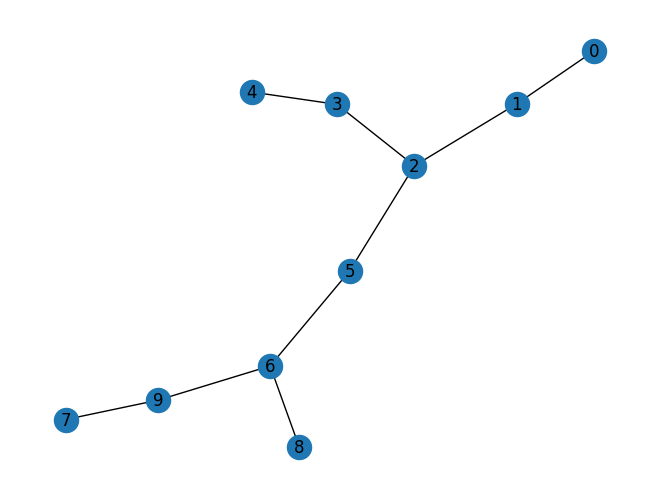

In [262]:
nx.draw(G1, with_labels = True)

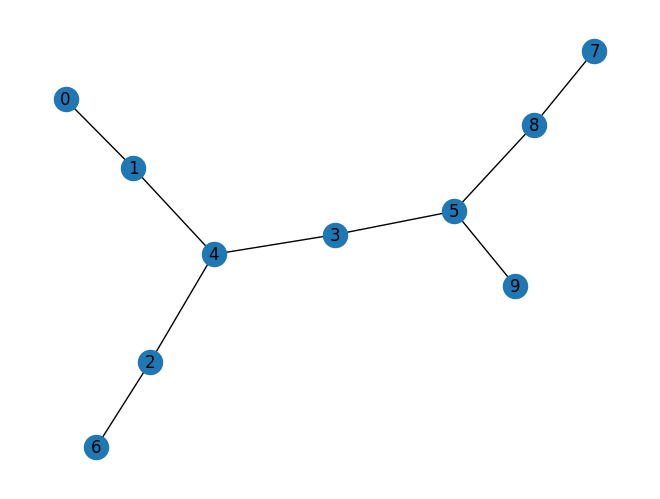

In [263]:
nx.draw(G2, with_labels = True)

## 4.2. Directed graph

In [264]:
# Generate 2 directed graphs
G1 = nx.DiGraph()
G2 = nx.DiGraph()

G1.add_nodes_from(range(0,9))
G2.add_nodes_from(range(0,9))
G1.add_edges_from([(0,1), (1,2), (2,3), (3,4), (2,5), (5,6), (6, 8), (6, 9), (7, 9)])
G2.add_edges_from([(0,1), (1,4), (2,4), (2,6), (4,3), (3,5), (5, 9), (5, 8), (7, 8)])

# Mapping 2 graph G1 and G2
GM = isomorphism.GraphMatcher(G2,G1)
print(f" Checking graph isomorphic: {GM.is_isomorphic()}")
GM.mapping

 Checking graph isomorphic: False


{}

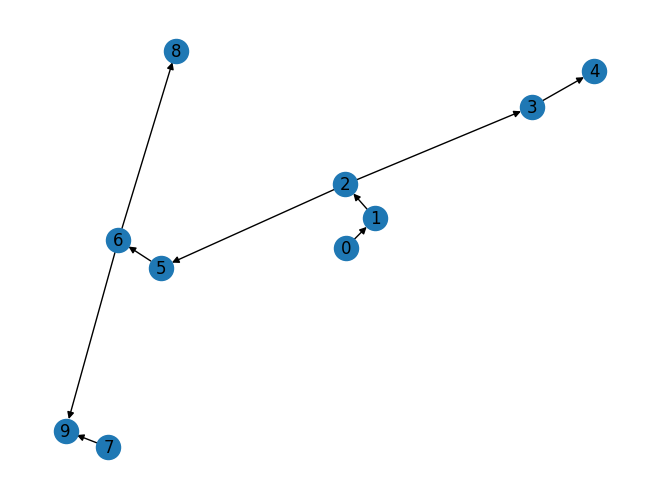

In [269]:
nx.draw(G1, with_labels = True)

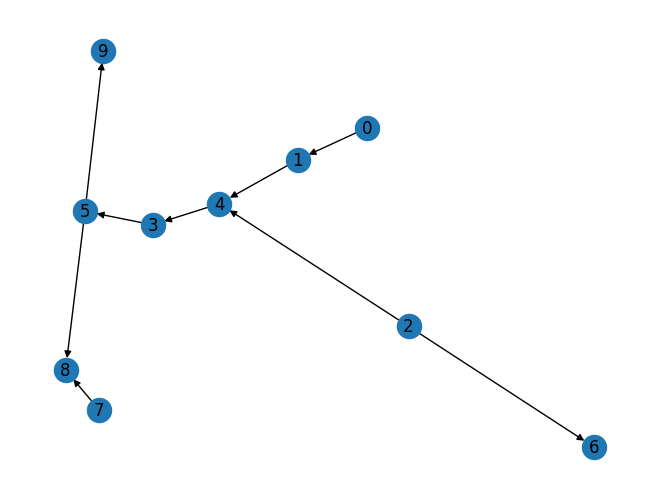

In [272]:
nx.draw(G2, with_labels = True)

## 4.3. Update the mismatch edge

In [273]:
# Generate 2 directed graphs
G1 = nx.DiGraph()
G2 = nx.DiGraph()

G1.add_nodes_from(range(0,9))
G2.add_nodes_from(range(0,9))
# Change graph edges
G1.add_edges_from([(0,1), (1,2), (2,3), (3,4), (2,5), (5,6), (6, 8), (6, 9), (7, 9)])
G2.add_edges_from([(0,1), (1,4), (4,2), (2,6), (4,3), (3,5), (5, 9), (5, 8), (7, 8)])

# Mapping 2 graph G1 and G2
GM = isomorphism.GraphMatcher(G2,G1)
print(f" Checking graph isomorphic: {GM.is_isomorphic()}")
GM.mapping

 Checking graph isomorphic: True


{0: 0, 1: 1, 4: 2, 2: 3, 6: 4, 3: 5, 5: 6, 9: 8, 8: 9, 7: 7}

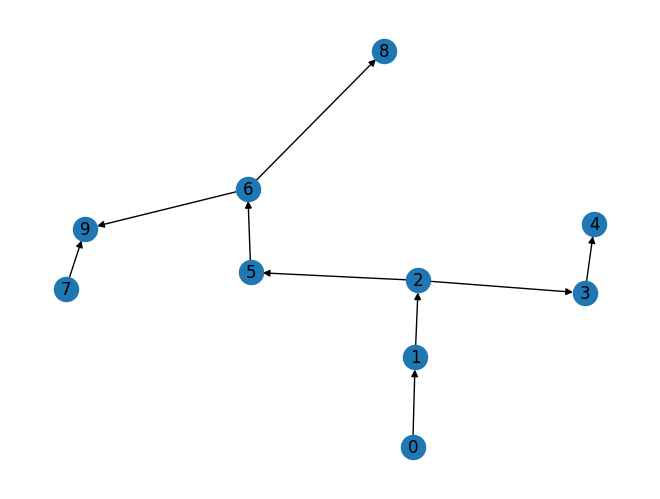

In [274]:
nx.draw(G1, with_labels = True)

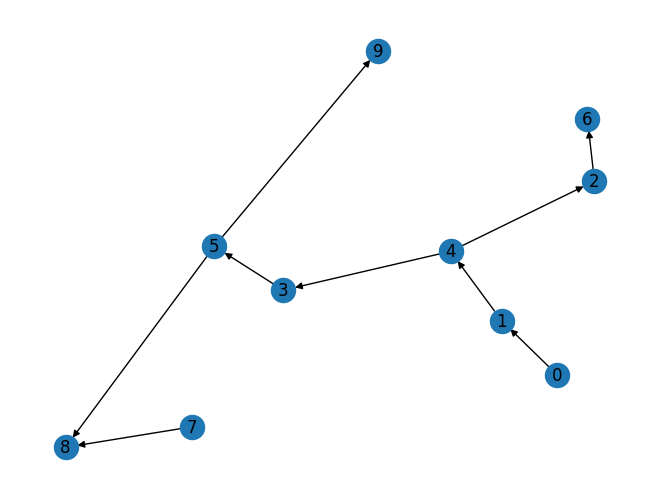

In [275]:
nx.draw(G2, with_labels = True)

# 5. VF2++

Citation: Jüttner, Alpár, and Péter Madarasi. "VF2++—An improved subgraph isomorphism algorithm." Discrete Applied Mathematics 242 (2018): 69-81.

The VF2++ algorithm, follows a similar logic to that of VF2, while also introducing new easy-to-check cutting rules and determining the optimal access order of nodes. It is also implemented in a non-recursive manner, which saves both time and space, when compared to its previous counterpart.

The main reason for the superiority of VF2++ over VF2 is twofold. Firstly, taking into account the structure and the node labeling of the graph, VF2++ determines a matching order in which most of the unfruitful branches of the search space can be pruned immediately. Secondly, introducing more efficient — nevertheless still easier to compute — cutting rules reduces the chance of going astray even further.

## 5.1. Algorithms:

Algorithm 2 is a high-level description of the matching order procedure of VF2++. It computes a BFS tree for each component in ascending order of their rarest node labels and largest degree, whose root vertex is the minimal node of its component. 
![image info](./data/VF2++_2.jpg)

Algorithm 3 is a method to process a level of the BFS tree, which appends the nodes of the current level in descending lexicographic order.
![image info](./data/VF2++_3.jpg)

In [276]:
# Generate 2 graphs
G1 = nx.Graph()
G2 = nx.Graph()

G1.add_nodes_from(range(0,9))
G2.add_nodes_from(range(0,9))
G1.add_edges_from([(0,1), (1,2), (2,3), (3,4), (2,5), (5,6), (6, 8), (6, 9), (7, 9)])
G2.add_edges_from([(0,1), (1,4), (2,4), (2,6), (4,3), (3,5), (5, 9), (5, 8), (7, 8)])


check_isomorphic = nx.vf2pp_is_isomorphic(G1, G2, node_label=None)
print(f" Checking graph isomorphic: {check_isomorphic}")

# Mapping 2 graph G1 and G2
nx.vf2pp_isomorphism(G1, G2, node_label=None)

 Checking graph isomorphic: True


{2: 4, 1: 1, 3: 2, 5: 3, 6: 5, 0: 0, 4: 6, 9: 8, 8: 9, 7: 7}

## 5.2. Graph with labels

In [277]:
G1 = nx.Graph()
G2 = nx.Graph()

G1.add_edges_from([(0,1), (1,2), (2,3), (3,4), (2,5), (5,6), (6, 8), (6, 9), (7, 9)])
G2.add_edges_from([(0,1), (1,4), (2,4), (2,6), (4,3), (3,5), (5, 9), (5, 8), (7, 8)])

mapped = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
label_list = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "K"]

# ADD labels as node attributes
nx.set_node_attributes(G1, dict(zip(G1, label_list)), "label")
nx.set_node_attributes(G2, dict(zip([mapped[u] for u in G1], label_list)), "label")

check_isomorphic = nx.vf2pp_is_isomorphic(G1, G2, node_label="label")
print(f" Checking graph isomorphic: {check_isomorphic}")

# Mapping 2 graph G1 and G2
nx.vf2pp_isomorphism(G1, G2, node_label="label")

 Checking graph isomorphic: False


{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 8: 'H', 9: 'I', 7: 'K'}


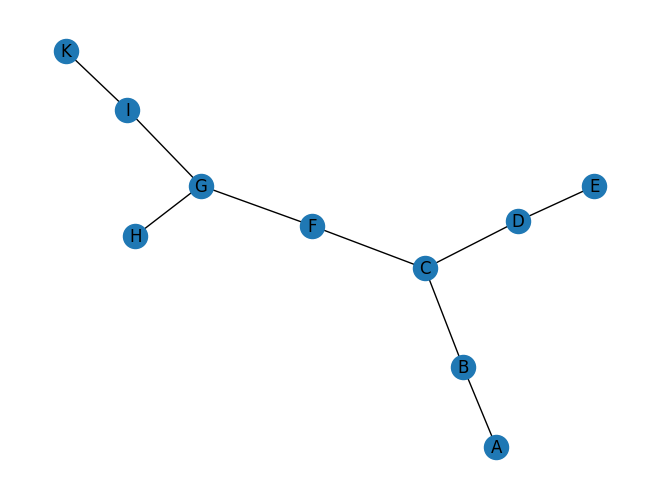

In [278]:
def draw_graph_with_labels(graph):
    labels = dict()
    names = nx.get_node_attributes(graph, 'label')
    print(names)
    for node in graph.nodes:
        labels[node] = f"{names[node]}"
    nx.draw(graph, labels=labels)
    

draw_graph_with_labels(G1)

{0: 'A', 1: 'B', 4: 'E', 2: 'C', 6: 'G', 3: 'D', 5: 'F', 9: 'I', 8: 'H', 7: 'K'}


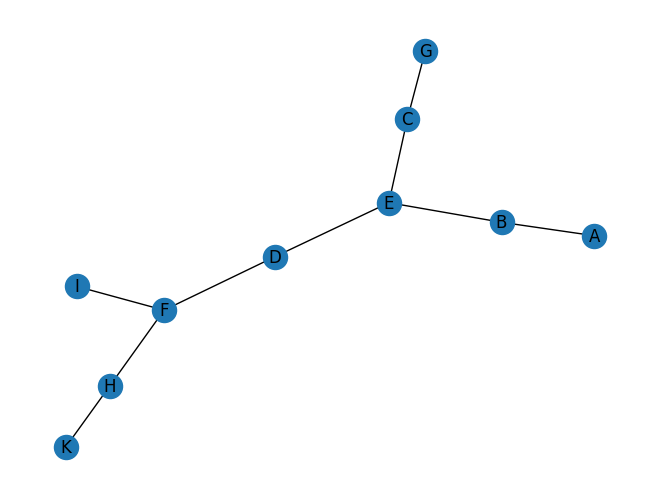

In [279]:
draw_graph_with_labels(G2)

In [280]:
G1 = nx.Graph()
G2 = nx.Graph()

# Create 2 similar graphs
G1.add_edges_from([(0,1), (1,2), (2,3), (3,4), (2,5), (5,6), (6, 8), (6, 9), (7, 9)])
G2.add_edges_from([(0,1), (1,2), (2,3), (3,4), (2,5), (5,6), (6, 8), (6, 9), (7, 9)])

mapped = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
label_list = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "K"]

# ADD labels as node attributes
nx.set_node_attributes(G1, dict(zip(G1, label_list)), "label")
nx.set_node_attributes(G2, dict(zip([mapped[u] for u in G1], label_list)), "label")

check_isomorphic = nx.vf2pp_is_isomorphic(G1, G2, node_label="label")
print(f" Checking graph isomorphic: {check_isomorphic}")

 Checking graph isomorphic: True


## 5.3. VF2++ in different graphs
Comparing the graph on the left L and the graph on the right R
![image info](./data/example_isomorphic.png)

In [282]:
# Create graph L
L = nx.Graph(
    [
        ("a", "g"),
        ("a", "h"),
        ("a", "i"),
        ("g", "b"),
        ("g", "c"),
        ("b", "h"),
        ("b", "j"),
        ("h", "d"),
        ("c", "i"),
        ("c", "j"),
        ("i", "d"),
        ("d", "j"),
    ]
)

# Create graph R
R = nx.Graph(
    [
        (1, 2),
        (1, 5),
        (1, 4),
        (2, 6),
        (2, 3),
        (3, 7),
        (3, 4),
        (4, 8),
        (5, 6),
        (5, 8),
        (6, 7),
        (7, 8),
    ]
)

### 5.3.1. Use VF2++ without considering node labels

In [283]:
check = nx.vf2pp_is_isomorphic(L, R, node_label=None)
print(f"Checking graph isomorphic: {check}")

# Graph Mapping
nx.vf2pp_isomorphism(L, R, node_label=None)

Checking graph isomorphic: True


{'i': 1, 'a': 2, 'c': 4, 'd': 5, 'g': 3, 'h': 6, 'j': 8, 'b': 7}

### 5.3.2. Use VF2++ considering node labels

In [284]:
# Assign label to each node
L_node_attributes = {
    "a": "blue",
    "g": "green",
    "b": "pink",
    "h": "red",
    "c": "yellow",
    "i": "orange",
    "d": "cyan",
    "j": "purple",
}

# Set node labels by using node attributes
nx.set_node_attributes(L, L_node_attributes, name="color")

# Assign label to each node
R_node_attributes = {
    1: "blue",
    2: "red",
    3: "cyan",
    4: "orange",
    5: "green",
    6: "pink",
    7: "purple",
    8: "yellow",
}

# Set node labels by using node attributes
nx.set_node_attributes(R, R_node_attributes, name="color")

check = nx.vf2pp_is_isomorphic(L, R, node_label="color")
print(f"Checking graph isomorphic: {check}")

# Graph Mapping
nx.vf2pp_isomorphism(L, R, node_label="color")

Checking graph isomorphic: True


{'i': 4, 'a': 1, 'c': 8, 'd': 3, 'g': 5, 'h': 2, 'j': 7, 'b': 6}

{1: 'A', 2: 'B', 3: 'C', 4: 'D'}


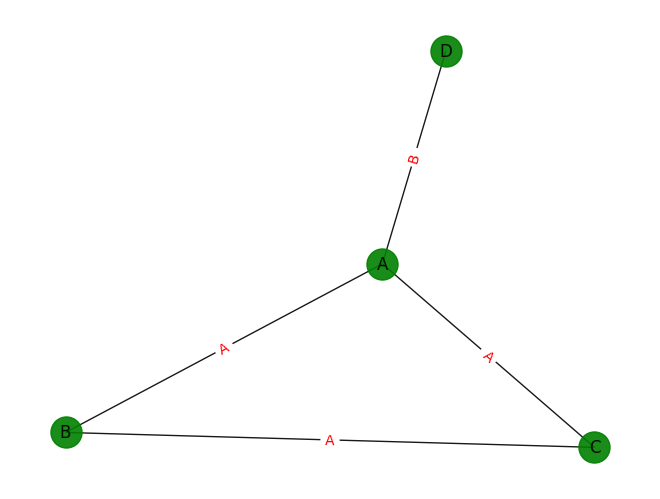

In [286]:
def draw_graph_with_labels(G):
    labels = dict()
    names = nx.get_node_attributes(G, 'label')
    print(names)
    for node in G.nodes:
        labels[node] = f"{names[node]}"
    pos = nx.spring_layout(G)
    plt.figure()
    nx.draw(
        G, pos, edge_color='black', width=1, linewidths=1,
        node_size=500, node_color='green', alpha=0.9,
        labels=labels
    )
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=nx.get_edge_attributes(G, "label"),
        font_color='red'
    )
    plt.axis('off')
    plt.show()
    
draw_graph_with_labels(G1)

{5: 'E', 6: 'F', 7: 'G', 8: 'H'}


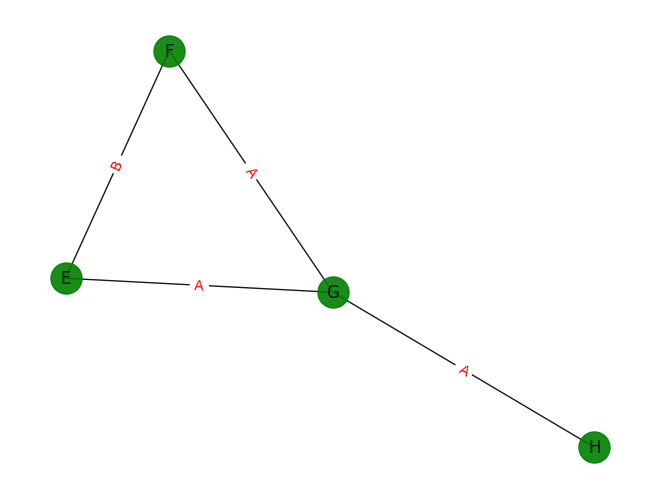

In [287]:
draw_graph_with_labels(G2)